In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from PIL import Image
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from keras.models import Model
from keras.regularizers import l1_l2
from keras.regularizers import l1
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import sklearn.metrics as metrics
import seaborn as sns
from datetime import datetime
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
import cv2
from google.colab import files
from tensorflow import keras

In [ ]:
# Daset Pins_face_recognition
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR2="/content/drive/My Drive/Face_recognition_project/"

In [ ]:
import re
# Function to split the extract only the name from the single picture files
def extract_name(string):
    name = string.split('.')[0]  # Split on period and take the first element
    name = ''.join(filter(str.isalpha, name))  # Keep only alphabetical characters
    return name

# to get class names from Pins_Face_Dataset
img_files = os.listdir(f"{DATA_DIR2}/Pins_Face_dataset_105_classes") 
y_img_labels = [extract_name(file_name) for file_name in img_files] 
# Print(y_img_labels)
unique_y_img_labels = list(set(y_img_labels))
print(unique_y_img_labels)

# # Puts a number on each class name in their order of apearance
dict_labels = [unique_y_img_labels.index(elt) for elt in unique_y_img_labels]
print(dict_labels)


number_of_classes = len(dict_labels)
print("The number of classes is :", number_of_classes)

['grantgustin', 'elonmusk', 'jeffbezos', 'ellenpage', 'galgadot']
[0, 1, 2, 3, 4]
{'grantgustin': 0, 'elonmusk': 1, 'jeffbezos': 2, 'ellenpage': 3, 'galgadot': 4}
The number of classes is : 5


In [ ]:
# now use the dict to construct digit labels according to each of the classes it belongs to 
# and stores it as a matrix (if i'm correct)
y_labels = np.array([dict_labels[elt] for elt in y_img_labels])
#print(y_labels)
y_labels.shape

(10,)

In [ ]:
# # #Takes A lot of fucking timmmmmmmmmmme!!!!!!!! like 5-7 min (only run when we did delete the file X_array on Gdrive)

# Code to retrieve the images in color, than, convert them to grayscale

# from PIL import Image
# # Create an empty list to store the images
# img_list = []
# # Loop through each file in the directory
# for file_name in img_files[]:
#     # Open the image and store it in a numpy array
#     image_opened = Image.open(f"{DATA_DIR2}/Pins_Face_dataset_105_classes/{file_name}")
#     # Converting images to grayscale
#     image_grayscale = image_opened.convert("L")
#     # Converting to an array
#     img_array = np.array(image_grayscale, dtype=np.uint8)
#     # Append the numpy array to the list of images
#     img_list.append(img_array)

# # Convert the list of numpy arrays to a numpy array object
# X = np.array(img_list, dtype=object)

# # Saving array
# def save_array_to_file(array, filename):
#     with open(filename, 'wb') as f:
#         np.save(f, array)
# X_saved = save_array_to_file(X, '/content/drive/My Drive/Face_recognition_project/X_array.npy')

In [ ]:
# !!!!!!!!!!!!!! Utilise trop de ram       To load array from saved array_file
def load_array_from_file(filename):
    with open(filename, 'rb') as f:
        array = np.load(f,allow_pickle=True)
        f.close()
    return array
X_loaded_array = load_array_from_file('/content/drive/My Drive/Face_recognition_project/X_array.npy')

In [ ]:
# print(X_loaded_array.dtype)
# print(y_labels.shape)   

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_loaded_array, y_labels, test_size=0.15, random_state=4)

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!! Utilise trop de ram
from skimage import exposure

def resize_images(X_train_):
  # resize images to 160x160
  X_train_resized = []
  for img in X_train_:
    img = img.astype(np.uint8)  # convert to uint8
    img_resized = cv2.resize(img, (160, 160))
    X_train_resized.append(img_resized)
  # convert to NumPy array and reshape
  X_train_resized_to_array_2d = np.array(X_train_resized)
  # resizing array from 2d to 3d array
  X_train_resized_to_array_3d = np.repeat(X_train_resized_to_array_2d[:,:,np.newaxis], 3, axis=2)
  X_train_reshaped = X_train_resized_to_array_3d.reshape(X_train_resized_to_array_3d.shape[0], 160, 160, 3)
  return X_train_reshaped

X_train_reshaped = resize_images(X_train)
X_test_reshaped = resize_images(X_test)

# Converting dtype('uint8') to dtype('float16') to normalize after
def Convert_unit8_to_float_and_normalize(array):
    arr_float = array.astype('float16')
    # Normalises images ( does the same as /255)
    converted_and_reshaped_array = exposure.rescale_intensity(arr_float, in_range=(0, 255), out_range=(0, 2))
    return converted_and_reshaped_array

X_train_normalized = Convert_unit8_to_float_and_normalize(X_train_reshaped)
X_test_normalized = Convert_unit8_to_float_and_normalize(X_test_reshaped)

X_train_tf = tf.convert_to_tensor(X_train_normalized, dtype=tf.float16)
X_test_tf  = tf.convert_to_tensor(X_test_normalized, dtype=tf.float16)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float16)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float16)

print(X_test_tf.dtype)
print(X_test_tf.dtype)

im_shape = (160, 160, 3)

<dtype: 'float16'>
<dtype: 'float16'>


In [ ]:
# AlexNet model 

# model = keras.models.Sequential([
#     keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(160,160,3)),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     keras.layers.Flatten(),
#     keras.layers.Dense(4096, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(4096, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(number_of_classes, activation='softmax')
# ])

In [ ]:
import tensorflow as tf
from keras.applications import MobileNetV2,ResNet50,VGG16,VGG19
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalAveragePooling2D,AveragePooling2D

im_shape = (160, 160, 3)
## Code to fit MobileNetV2
# trained_model=MobileNetV2(input_shape=(160,160,3),           
#                     include_top=False,
#                     weights='imagenet')  
# trained_model.trainable=True  #Un-Freeze all the pretrained layers of 'MobileNetV2 for Training.
# last_layer=trained_model.get_last_layer('dense_2')   
# last_layer_output=last_layer.output
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))

# #InceptionV3
# pretrained_model= tf.keras.applications.InceptionV3(include_top=False,
#                    input_shape=im_shape,
#                    pooling='avg',classes=number_of_classes,
#                    weights='imagenet')

#VGG19
# pretrained_model= tf.keras.applications.VGG19(include_top=False,
#                    input_shape=im_shape,
#                    pooling='avg',classes=number_of_classes,
#                    weights='imagenet')

#VGG16  (meilleur modèle jusque la)
pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=im_shape,
                   pooling='avg',classes=number_of_classes,
                   weights='imagenet')

# #MobileNetV2
# pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
#                    input_shape=im_shape,
#                    pooling='avg',classes=number_of_classes,
#                    weights='imagenet')

# #ResNet50
# pretrained_model= tf.keras.applications.ResNet50(include_top=False,
#                    input_shape=im_shape,
#                    pooling='avg',classes=number_of_classes,
#                    weights='imagenet')

model = Sequential()
for each_layer in pretrained_model.layers:
        each_layer.trainable=True
model.add(pretrained_model)
model.add(Flatten())
# model.add(Dense(96, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(96, activation='relu'))
# model.add(Dropout(0.2))
# # model.add(Dense(512, activation='relu'))
# # model.add(Dropout(0.2))
model.add(Dense(105, activation='softmax'))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
# #Add a Dropout layer.
# x = tf.keras.layers.Dropout(0.5)(x) 
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(0.5)(x) 

# x=tf.keras.layers.Dense(256, activation='relu')(x)
# # x = tf.keras.layers.BatchNormalization()(x)
# # x = tf.keras.layers.Flatten()(x)
# # x = tf.keras.layers.Dropout(0.2)(x) 
# x=tf.keras.layers.Dense(512, activation='relu')(x)
# # Add a final softmax layer for classification.
# x = tf.keras.layers.Dense(105,activation='softmax')(x)
# model = tf.keras.Model(trained_model.input,x) 


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy'],
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 105)               53865     
                                                                 
Total params: 14,768,553
Trainable params: 14,768,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start_time = datetime.now()

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.0001, mode="auto", patience=1, min_lr=0.0001)
history=model.fit(
                      np.array(X_train_tf), np.array(y_train_tf),
                      batch_size=256, 
                      epochs=70,
                      validation_data = (np.array(X_test_tf), np.array(y_test_tf)),
                      verbose=2,
                      #callbacks=[reduce_lr],
                      )
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/70
58/58 - 15s - loss: 4.5175 - accuracy: 0.0265 - val_loss: 4.1646 - val_accuracy: 0.0533 - 15s/epoch - 252ms/step
Epoch 2/70
58/58 - 12s - loss: 3.5249 - accuracy: 0.1587 - val_loss: 2.9243 - val_accuracy: 0.2582 - 12s/epoch - 212ms/step
Epoch 3/70
58/58 - 12s - loss: 2.3239 - accuracy: 0.3970 - val_loss: 2.1044 - val_accuracy: 0.4649 - 12s/epoch - 213ms/step
Epoch 4/70
58/58 - 12s - loss: 1.5352 - accuracy: 0.5840 - val_loss: 1.7430 - val_accuracy: 0.5439 - 12s/epoch - 211ms/step
Epoch 5/70
58/58 - 12s - loss: 1.0645 - accuracy: 0.7044 - val_loss: 1.5649 - val_accuracy: 0.5811 - 12s/epoch - 211ms/step
Epoch 6/70
58/58 - 12s - loss: 0.7210 - accuracy: 0.7929 - val_loss: 1.4657 - val_accuracy: 0.6356 - 12s/epoch - 212ms/step
Epoch 7/70
58/58 - 12s - loss: 0.4728 - accuracy: 0.8611 - val_loss: 1.4570 - val_accuracy: 0.6628 - 12s/epoch - 213ms/step
Epoch 8/70
58/58 - 12s - loss: 0.2823 - accuracy: 0.9152 - val_loss: 1.3621 - val_accuracy: 0.6770 - 12s/epoch - 211ms/step
Epoch 9/

In [ ]:
# Saving model
model.save('/content/drive/My Drive/Face_recognition_project/my_model_3.h5')
saved_model = tf.keras.models.load_model('/content/drive/My Drive/Face_recognition_project/my_model_3.h5')

In [ ]:
# Evaluate the model on the test data
train_loss, train_acc = saved_model.evaluate(X_train_tf, y_train_tf)
print('Train accuracy:', train_acc)

462/462 [==============================] - 5s 11ms/step - loss: 8.5536e-06 - accuracy: 1.0000
Train accuracy: 1.0


In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = saved_model.evaluate(X_test_tf, y_test_tf)
print('Test accuracy:', test_acc)

82/82 [==============================] - 1s 11ms/step - loss: 1.6763 - accuracy: 0.7745
Test accuracy: 0.7744534015655518


In [ ]:
yhat = saved_model.predict(X_test_tf)
predictions = [np.argmax(elt) for elt in yhat]
print(predictions)

82/82 [==============================] - 1s 9ms/step
[45, 81, 74, 28, 76, 93, 2, 57, 82, 100, 60, 41, 99, 40, 68, 38, 97, 45, 29, 2, 90, 31, 31, 89, 5, 35, 57, 48, 66, 27, 8, 7, 79, 100, 9, 46, 57, 103, 82, 38, 51, 91, 91, 101, 8, 30, 0, 9, 21, 2, 60, 65, 51, 63, 79, 62, 46, 40, 6, 94, 17, 12, 32, 104, 72, 73, 56, 74, 41, 37, 98, 90, 93, 19, 92, 11, 12, 78, 96, 30, 55, 56, 103, 87, 10, 84, 41, 77, 79, 25, 87, 91, 94, 93, 91, 30, 87, 35, 47, 28, 73, 90, 93, 47, 66, 86, 11, 16, 5, 3, 5, 20, 38, 99, 51, 94, 66, 6, 18, 101, 19, 73, 93, 47, 12, 66, 4, 99, 8, 29, 43, 104, 27, 51, 24, 5, 16, 66, 104, 72, 31, 46, 12, 24, 32, 24, 0, 37, 95, 98, 16, 70, 95, 27, 75, 47, 95, 46, 14, 55, 8, 84, 81, 92, 62, 0, 87, 37, 38, 96, 93, 97, 93, 79, 30, 34, 91, 102, 54, 12, 21, 78, 27, 12, 80, 91, 54, 38, 80, 55, 22, 12, 8, 71, 40, 80, 34, 79, 79, 15, 98, 9, 65, 77, 53, 102, 51, 25, 50, 67, 5, 71, 7, 47, 87, 3, 51, 12, 52, 25, 69, 24, 96, 49, 50, 94, 33, 90, 22, 58, 81, 72, 94, 1, 58, 67, 80, 33, 30, 16, 66

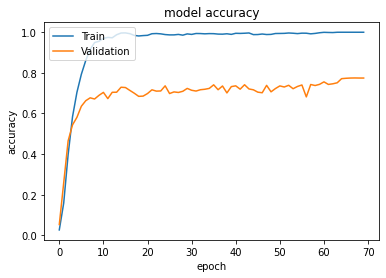

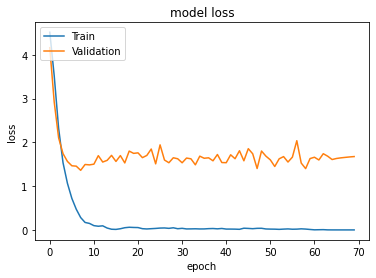

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<Axes: >

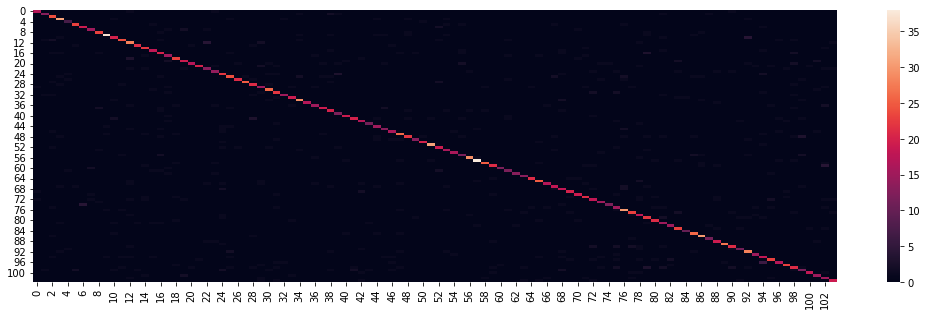

In [ ]:
my_conf_matrix = confusion_matrix(y_test, predictions)

import sklearn.metrics as metrics
import seaborn as sns
plt.figure(1, figsize=(18,5))
sns.heatmap(metrics.confusion_matrix(y_test, predictions))